# LKJ Prior for fitting a Multivariate Normal Model

Author: [Austin Rochford](http://www.austinrochford.com)

Outside of the [beta](https://en.wikipedia.org/wiki/Beta_distribution)-[binomial](https://en.wikipedia.org/wiki/Binomial_distribution) model, the multivariate normal model is likely the most studied Bayesian model in history. `PyMC3` supports sampling from the [LKJ distribution](http://www.sciencedirect.com/science/article/pii/S0047259X09000876). The LKJ distribution represents the distribution on correlation matrices and is conjugate to the multivariate normal distribution. This post will show how to fit a simple multivariate normal model using `pymc3` with a normal-LKJ prior.

First, we generate some two-dimensional sample data.

In [1]:
%matplotlib inline

In [2]:
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import tensor as tt

In [3]:
np.random.seed(3264602) # from random.org

In [4]:
N = 100

mu_actual = sp.stats.uniform.rvs(-5, 10, size=2)

cov_actual_sqrt = sp.stats.uniform.rvs(0, 2, size=(2, 2))
cov_actual = np.dot(cov_actual_sqrt.T, cov_actual_sqrt)

x = sp.stats.multivariate_normal.rvs(mu_actual, cov_actual, size=N)

In [5]:
var, U = np.linalg.eig(cov_actual)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

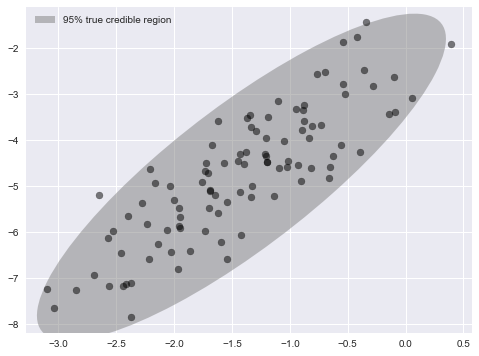

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

blue = sns.color_palette()[0]

e = Ellipse(mu_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=-angle)
e.set_alpha(0.5)
e.set_facecolor('gray')
e.set_zorder(10);
ax.add_artist(e);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.5, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.5)
ax.legend([rect], ['95% true credible region'], loc=2);

The sampling distribution for our model is $x_i \sim N(\mu, \Lambda)$, where $\Lambda$ is the [precision matrix](https://en.wikipedia.org/wiki/Precision_(statistics)) of the distribution.  The precision matrix is the inverse of the covariance matrix.  The support of the LKJ distribution is the set of [correlation matrices](https://en.wikipedia.org/wiki/Correlation_and_dependence#Correlation_matrices), not covariance matrices.  We will use the separation strategy from [Barnard et al.](http://www3.stat.sinica.edu.tw/statistica/oldpdf/A10n416.pdf) to combine an LKJ prior on the correlation matrix with a prior on the standard deviations of each dimension to produce a prior on the covariance matrix.

Let $\sigma$ be the vector of standard deviations of each component of our normal distribution, and $\mathbf{C}$ be the correlation matrix.   The relationship

$$\Sigma = \operatorname{diag}(\sigma)\ \mathbf{C} \operatorname{diag}(\sigma)$$

shows that priors on $\sigma$ and $\mathbf{C}$ will induce a prior on $\Sigma$.  Following Barnard et al., we place a standard [lognormal](https://en.wikipedia.org/wiki/Log-normal_distribution) prior each the elements $\sigma$, and an LKJ prior on the correlation matric $\mathbf{C}$.  The LKJ distribution requires a shape parameter $\nu > 0$.  If $\mathbf{C} \sim LKJ(\nu)$, then $f(\mathbf{C}) \propto |\mathbf{C}|^{\nu - 1}$ (here $|\cdot|$ is the determinant).

We can now begin to build this model in `pymc3`. As you can see, we are passing summary statistics to `testval` which will be used as the starting point when we do inference further below. When summary statistics are available, it is always a good idea to use them in this manner.

In [7]:
init_sigma = np.std(x, axis=0)
init_corr = np.corrcoef(x, rowvar=0)[0, 1]
with pm.Model() as model:
    sigma = pm.Lognormal('sigma', np.zeros(2), np.ones(2), shape=2, testval=init_sigma)
    
    nu = pm.Uniform('nu', 0, 5)
    C_triu = pm.LKJCorr('C_triu', nu, 2, testval=init_corr) 

There is a slight complication in `pymc3`'s handling of the `LKJCorr` distribution; `pymc3` represents the support of this distribution as a one-dimensional vector of the upper triangular elements of the full covariance matrix. 

In [8]:
C_triu.tag.test_value.shape

(1,)

In order to build a the full correlation matric $\mathbf{C}$, we first build a $2 \times 2$ tensor whose values are all `C_triu` and then set the diagonal entries to one.  (Recall that a correlation matrix must be symmetric and positive definite with all diagonal entries equal to one.)  We can then proceed to build the covariance matrix $\Sigma$ and the precision matrix $\Lambda$.

In [9]:
with model:
    C = pm.Deterministic('C', tt.fill_diagonal(C_triu[np.zeros((2, 2), dtype=np.int64)], 1.))
    
    sigma_diag = pm.Deterministic('sigma_mat', tt.nlinalg.diag(sigma))
    cov = pm.Deterministic('cov', tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag))

In [10]:
cov.tag.test_value

array([[ 0.54737873,  0.88092866],
       [ 0.88092866,  1.98234664]])

While defining `C` in terms of `C_triu` was simple in this case because our sampling distribution is two-dimensional, the example from this [StackOverflow question](http://stackoverflow.com/questions/29759789/modified-bpmf-in-pymc3-using-lkjcorr-priors-positivedefiniteerror-using-nuts) shows how to generalize this transformation to arbitrarily many dimensions.

Finally, we define the prior on $\mu$ and the sampling distribution.

In [11]:
with model:
    mu = pm.MvNormal('mu', 0, cov, shape=2, testval=np.mean(x, axis=0))
    
    x_ = pm.MvNormal('x', mu, cov, observed=x)

We are now ready to fit this model using `pymc3`.

In [26]:
with model:
    trace = pm.sample(1000, pm.Metropolis(), tune=1000)

100%|██████████| 2000/2000 [00:03<00:00, 545.75it/s]


We see that the posterior estimate of $\mu$ is reasonably accurate.

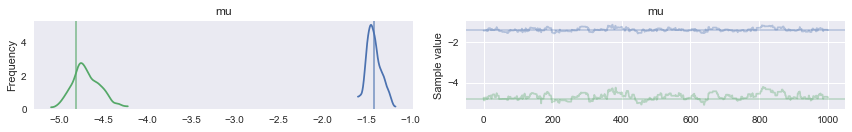

In [30]:
pm.traceplot(trace, varnames=['mu'], lines={'mu':mu_actual});

The estimates of the standard deviations are certainly biased.

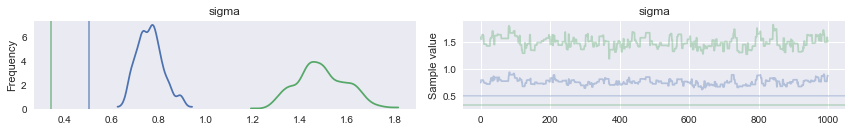

In [34]:
pm.traceplot(trace, varnames=['sigma'], lines={'sigma': np.diag(cov_actual_sqrt)});

However, the 95% posterior credible region is visually quite close to the true credible region, so we can be fairly satisfied with our model.

In [35]:
post_cov = trace['cov'].mean(axis=0)

post_sigma, post_U = np.linalg.eig(post_cov)
post_angle = 180. / np.pi * np.arccos(np.abs(post_U[0, 0]))

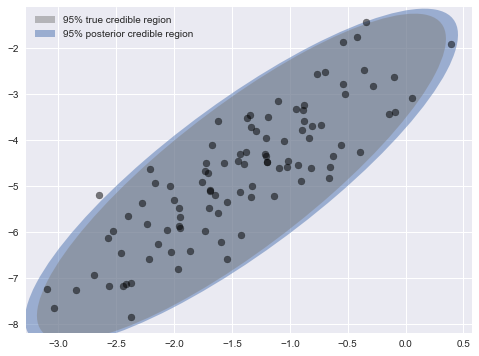

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

blue = sns.color_palette()[0]

e = Ellipse(mu_actual, 2 * np.sqrt(5.991 * post_sigma[0]), 2 * np.sqrt(5.991 * post_sigma[1]), angle=-post_angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(9);
ax.add_artist(e);

e = Ellipse(mu_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=-angle)
e.set_alpha(0.5)
e.set_facecolor('gray')
e.set_zorder(10);
ax.add_artist(e);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.5, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.5)
post_rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect, post_rect],
          ['95% true credible region',
           '95% posterior credible region'],
          loc=2);